In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. Defining Custom Layers 

The fundamental data structure in neural networks is the layer. A Layer is an object that encapsulates some state (weights) and some computation (a forward pass). 

`tf.keras.layers.Layer` is the base class of all Keras layers, and it inherits from `tf.Module`

#### a)  Define a Layer

In [2]:
class MyDense(tf.keras.layers.Layer):
    # Adding **kwargs to support base Keras layer arguments
    def __init__(self, in_features, out_features, **kwargs):
        super(MyDense, self).__init__(**kwargs)
        self.w = tf.Variable(
          tf.random.normal([in_features, out_features]), name='w')
        self.b = tf.Variable(tf.zeros([out_features]), name='b')
    
    def call(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)


In [3]:
# Instantiate your layer

simple_layer = MyDense(name="simple", in_features=2, out_features=4)


# Call the layer on a sample input

x = tf.random.normal((4,2))
y = simple_layer(x)

print(y)

tf.Tensor(
[[1.383455  0.6785611 0.        0.       ]
 [0.        0.        0.        0.       ]
 [1.6735854 1.0778134 0.        0.5693652]
 [0.        0.        0.        0.       ]], shape=(4, 4), dtype=float32)


2021-09-22 13:47:35.317205: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-22 13:47:35.321151: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### b) Build Method 

It is often convenient to delay creating variables until the input shape is fixed.

In [4]:
class MyDense(tf.keras.layers.Layer):
    
    def __init__(self, units=32, **kwargs):
        super(MyDense, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], self.units]), name='w')
        self.b = tf.Variable(tf.zeros([self.units]), name='b')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [5]:
# Instantiate your layer

flexible_layer = MyDense(name="simple", units=4)


# Call the layer on a sample input

x = tf.random.normal((2,2))
y = flexible_layer(x)

print(y)

tf.Tensor(
[[ 0.23956239 -3.460109    0.32127348  1.7701747 ]
 [-0.04826313 -0.3767929   0.04879715  0.31217265]], shape=(2, 4), dtype=float32)


In [6]:
# At this point we can inspect the variable

flexible_layer.variables

[<tf.Variable 'simple/w:0' shape=(2, 4) dtype=float32, numpy=
 array([[-0.27470055,  2.6943727 , -0.23379846, -1.2368518 ],
        [-0.94584095,  0.41923955,  0.1313845 ,  1.2579261 ]],
       dtype=float32)>,
 <tf.Variable 'simple/b:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

In [7]:
# We can also call the variables by name

flexible_layer.b

<tf.Variable 'simple/b:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>

#### c) Non-trainable weights 

By default, the variables in a layer are trainable, i.e. they will tracked by the Gradient Tape and will be updated during backpropagation. However, we can also specify certain weights to be non-trainable.

In [8]:
class MyDense(tf.keras.layers.Layer):
    
    def __init__(self, units=32, **kwargs):
        super(MyDense, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], self.units]), name='w', trainable=True)
        self.b = tf.Variable(tf.zeros([self.units]), name='b', trainable=False)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [9]:
# Instantiate the layer

my_new_layer = MyDense(units=16)

x = tf.random.normal((2,2))
y = my_new_layer(x)

y.shape

TensorShape([2, 16])

In [10]:
print("weights:", len(my_new_layer.weights))
print("non-trainable weights:", len(my_new_layer.non_trainable_weights))


# It's not included in the trainable weights:
print("\n trainable_weights:", my_new_layer.trainable_weights)
print("\n non trainable_weights:", my_new_layer.non_trainable_weights)

weights: 2
non-trainable weights: 1

 trainable_weights: [<tf.Variable 'my_dense/w:0' shape=(2, 16) dtype=float32, numpy=
array([[ 0.25838092, -0.93933207,  0.5070162 , -1.3070086 ,  2.0693195 ,
        -0.3360005 , -1.0204206 ,  0.8578458 , -0.27278   , -2.643488  ,
         2.1546938 ,  1.3140656 , -0.5776343 ,  0.29571944,  1.6056204 ,
        -3.27223   ],
       [-0.3278368 ,  0.93234366, -0.6313154 ,  0.5519521 , -1.42223   ,
        -1.3002957 ,  1.3936783 , -0.7722009 , -0.3169182 ,  0.39923579,
         0.6824974 ,  0.5724764 , -2.4262466 ,  1.6392792 ,  0.5200516 ,
        -0.32713383]], dtype=float32)>]

 non trainable_weights: [<tf.Variable 'my_dense/b:0' shape=(16,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>]


#### d) training arg in call()  

In [11]:
class CustomDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

In [12]:
dropuout = CustomDropout(rate=0.5)

x = tf.random.normal((2,2))
print('input: ', x)


# During training
output_during_training = dropuout(x, training=True)
print('\n output_during_training: ', output_during_training)


# During inference
output_during_inference = dropuout(x, training=False)
print('\n output_during_inference: ', output_during_inference)

input:  tf.Tensor(
[[0.9578399  0.80969965]
 [1.1870881  1.7834424 ]], shape=(2, 2), dtype=float32)

 output_during_training:  tf.Tensor(
[[0.        0.       ]
 [2.3741763 3.5668848]], shape=(2, 2), dtype=float32)

 output_during_inference:  tf.Tensor(
[[0.9578399  0.80969965]
 [1.1870881  1.7834424 ]], shape=(2, 2), dtype=float32)


#### e) Recursively composible  

It also possible to compose a layer out of other layers. The outer layer will automatically track the weights of the inner layer.

In [13]:
# Let's assume we are reusing the Linear class
# with a `build` method that we defined above.


class MLPBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.dense_1 = MyDense(32)
        self.dense_2 = MyDense(32)
        self.dense_3 = MyDense(1)

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = tf.nn.relu(x)
        x = self.dense_2(x)
        x = tf.nn.relu(x)
        return self.dense_3(x)


mlp = MLPBlock()
y = mlp(tf.ones(shape=(3, 64)))  # The first call to the `mlp` will create the weights
print("weights:", len(mlp.weights))
print("trainable weights:", len(mlp.trainable_weights))
print("y.shape: ", y.shape)

weights: 6
trainable weights: 3
y.shape:  (3, 1)


## 2. Defining Models: Three Levels of abstraction

Given a set of (either predefined or custom defined) layers, we can begin to start composing them into a DAG to define a model. A `tf.keras.Model` is similar to a `tf.keras.layers.Layer` except that models come with extra functionality that make them easy to train, evaluate, load, save, and even train on multiple machines.

#### a) Sequential

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

In [14]:
# There are two ways to define a sequential model:

# 1. Either as a list of layers

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(4,)),
        tf.keras.layers.Dense(32),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(16),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1)
    ]
)


# 2. Or instantiate a Sequential Model and add layers by calling the .add() method on it
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(4,)))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(1))

In [15]:
# Now we can call the model on an Input Tensor
x = tf.ones((16, 4))
y = model(x)

print(y.shape)

(16, 1)


In [16]:
# We can call summary method to display the graph
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


#### b) Functional API 

The __Functional API__ is more flexible than Sequential, and specifically come in handy when the model has non-linear topology, shared layers and/or multiple inputs, outputs.

First, lets redefine the above model in Functional API.

In [17]:
inputs = tf.keras.Input(shape=(4,))

x = tf.keras.layers.Dense(32)(inputs)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.ReLU()(x)

outputs = tf.keras.layers.Dense(1)(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs, name="functional_model")

In [18]:
model.summary()

Model: "functional_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                160       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 705
Trainable params: 705
Non-trainable params: 0
____________________________________________________

With Functional API, it's easy to define more complex topologies. Lets define a model with multiple inputs and outputs.

Let's say we want a model that takes in a few weather data variables on any given day to predict temperature and humidity for the same day:

Inputs:

- Pressure
- Precipitation
- Clouds
- Wind


Outputs:

- Temperature
- Humidity

In [19]:
# Now lets build this model

pressure_input = tf.keras.layers.Input(shape=(1,), name='pressure')
precipitation_input = tf.keras.layers.Input(shape=(1,), name='precipitation')
clouds_input = tf.keras.layers.Input(shape=(1,), name='clouds')
wind_input = tf.keras.layers.Input(shape=(1,), name='wind')


# Lets pass the pressure and precipitaion through a one stack of linear layers, and clouds and wind through another
x = tf.keras.layers.concatenate([pressure_input, precipitation_input])
x = tf.keras.layers.Dense(units=32, activation='relu')(x)
x = tf.keras.layers.Dense(units=16, activation='relu')(x)


y = tf.keras.layers.concatenate([clouds_input, wind_input])
y = tf.keras.layers.Dense(units=32, activation='relu')(y)
y = tf.keras.layers.Dense(units=16, activation='relu')(y)


# Lets merge the two branches and send through a few more layers
z = tf.keras.layers.concatenate([x,y])
z = tf.keras.layers.Dense(units=32, activation='relu')(z)
z = tf.keras.layers.Dense(units=16, activation='relu')(z)

# Finally split again into two outputs
temperature = tf.keras.layers.Dense(units=1, name='temperature')(z)
humidity = tf.keras.layers.Dense(units=1, name='humidity')(z)


multiple_inp_model = tf.keras.Model(inputs=[pressure_input, precipitation_input, clouds_input, wind_input], 
                       outputs=[temperature, humidity], name="multi_input_output_model")

In [20]:
# We can print the summary but it might be difficult to visualize the graph
multiple_inp_model.summary()

Model: "multi_input_output_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pressure (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
precipitation (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
clouds (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
wind (InputLayer)               [(None, 1)]          0                                            
___________________________________________________________________________

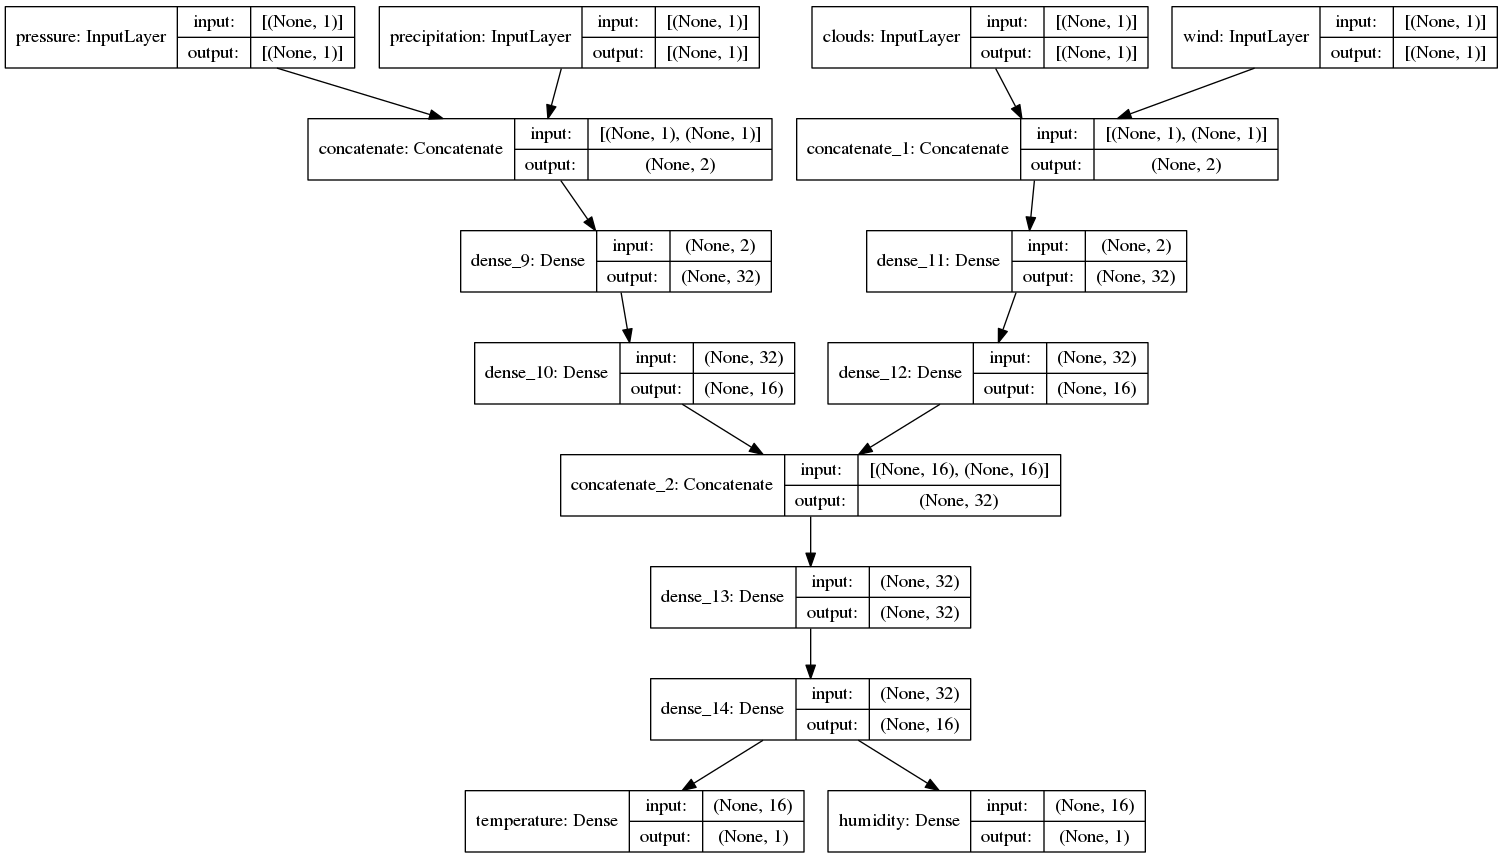

In [21]:
# Luckily we can also plot the model
tf.keras.utils.plot_model(multiple_inp_model, show_shapes=True)

#### c) Subclassing 

In [23]:
class FCN(tf.keras.Model):

    def __init__(self):
        super(FCN, self).__init__()
        self.dense_1 = tf.keras.layers.Dense(32)
        self.dense_2 = tf.keras.layers.Dense(16)
        self.dense_3 = tf.keras.layers.Dense(1)
        self.relu = tf.keras.layers.ReLU()


    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.relu(x)
        x = self.dense_2(x)
        x = self.relu(x)
        return self.dense_3(x)

In [24]:
model = FCN()


# Call the model on an Input Tensor
x = tf.ones((16, 4))
y = model(x)

print(y.shape)

(16, 1)


In [25]:
# Print summary

model.summary()

Model: "fcn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             multiple                  160       
_________________________________________________________________
dense_16 (Dense)             multiple                  528       
_________________________________________________________________
dense_17 (Dense)             multiple                  17        
_________________________________________________________________
re_lu_6 (ReLU)               multiple                  0         
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


## 3. Training: Three Levels of abstraction

For this exercise, we will fix the model architecture (a small CNN) and train it on the MNIST dataset. 

In [26]:
# Prepare Dataset

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

train_images, val_images = train_images[:50000], train_images[50000:]
train_labels, val_labels = train_labels[:50000], train_labels[50000:]

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [27]:
# Define Model
from tensorflow.keras import layers

Input = tf.keras.layers.Input(shape=(28,28,1))

x = layers.Conv2D(32, (3, 3), activation='relu')(Input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

Output = layers.Dense(10, activation='softmax')(x)

my_CNN = tf.keras.Model(inputs=Input, outputs=Output)
my_CNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0     

#### a) Model.fit() method 

To use the built in methods `(Model.fit(), Model.evaluate(), Model.predict() `, we simply need to specify the
- optimizer
- loss
- metrics

and compile the model.

In [28]:
my_CNN.compile(
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(),
    # Loss function to minimize
    loss = tf.keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics = [tf.keras.metrics.CategoricalAccuracy()],
)

The `.fit()` method will accept `numpy arrays`, `tf.data.Dataset` objects and `data generators`. Here we will input the MNIST data as a numpy array.

The `.fit()` method can slice the data into batches, and will iterate over the entire dataset for a given number of epochs. Additionally, after each epoch it will evaluate on a hold-out validation set if specified.

In [29]:
history = my_CNN.fit(
    train_images,
    train_labels,
    batch_size=64,
    epochs=2,
    validation_data=(val_images, val_labels),
)

2021-09-22 13:25:06.588961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-22 13:25:06.620405: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3783000000 Hz


Epoch 1/2
782/782 [==============================] - 65s 83ms/step - loss: 0.2030 - categorical_accuracy: 0.9373 - val_loss: 0.0958 - val_categorical_accuracy: 0.9721
Epoch 2/2
782/782 [==============================] - 65s 83ms/step - loss: 0.0562 - categorical_accuracy: 0.9825 - val_loss: 0.0510 - val_categorical_accuracy: 0.9850


The returned history object holds a record of the loss and metric values recorded at the end of each epoch during training:

In [30]:
history.history

{'loss': [0.202972874045372, 0.056160375475883484],
 'categorical_accuracy': [0.9373000264167786, 0.9824600219726562],
 'val_loss': [0.0957731083035469, 0.050980113446712494],
 'val_categorical_accuracy': [0.972100019454956, 0.9850000143051147]}

After training, we can call the `evaaluate` or `predict` methods on a test set.

In [31]:
my_CNN.evaluate(test_images, test_labels)

313/313 [==============================] - 4s 13ms/step - loss: 0.0415 - categorical_accuracy: 0.9862


[0.04154766723513603, 0.9861999750137329]

In [32]:
predictions = my_CNN.predict(test_images, verbose=1)

313/313 [==============================] - 4s 13ms/step


In [33]:
predictions.shape

(10000, 10)

###### What if there are multiple outputs? 

In [34]:
#multiple_inp_model.summary()

In [35]:
multiple_inp_model.compile(
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(),
    
    # Loss function to minimize
    loss = {
        'temperature': tf.keras.losses.MeanSquaredError(),
        'humidity': tf.keras.losses.CategoricalCrossentropy()
    },
    
    # List of metrics to monitor
    metrics = {
        'temperature': [tf.keras.metrics.MeanAbsoluteError(),],
        'humidity': [tf.keras.metrics.CategoricalAccuracy(),]
    }
)

#### b) Customizing what happens in Model.fit()

To customize what `fit()` does, we just need to override the `train_step(self, data)` method of the `Model` class.

Let's do this with our simple CNN from above.

In [36]:
# Source: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

loss_tracker = tf.keras.metrics.Mean(name="loss")
accuracy_tracker = tf.keras.metrics.CategoricalAccuracy(name="accuracy")


class CustomModel(tf.keras.Model):
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = tf.keras.losses.categorical_crossentropy(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        accuracy_tracker.update_state(y, y_pred)
        return {"loss": loss_tracker.result(), "acc": accuracy_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, accuracy_tracker]

In [37]:
# Define the architecture
Input = tf.keras.layers.Input(shape=(28,28,1))

x = layers.Conv2D(32, (3, 3), activation='relu')(Input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

Output = layers.Dense(10, activation='softmax')(x)




# Reconstruct an instance of our CNN model
my_new_CNN = CustomModel(inputs=Input, outputs=Output)

# Now during compilation we don't need to pass loss or metrics
my_new_CNN.compile(optimizer="adam")

# Print summary
my_new_CNN.summary()

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

In [38]:
# Train 
my_new_CNN.fit(
    train_images,
    train_labels,
    batch_size=64,
    epochs=2,)

Epoch 1/2
782/782 [==============================] - 61s 77ms/step - loss: 0.2087 - acc: 0.8524
Epoch 2/2
782/782 [==============================] - 61s 77ms/step - loss: 0.0566 - acc: 0.9801


#### c) Training Loop from scratch

In [39]:
# Define Model

Input = tf.keras.layers.Input(shape=(28,28,1))

x = layers.Conv2D(32, (3, 3), activation='relu')(Input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

Output = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=Input, outputs=Output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0   

In [40]:
# Reshape data to simulate batches

batch_size= 16

train_images = train_images.reshape(-1, batch_size, 28,28,1)
val_images = val_images.reshape(-1, batch_size, 28,28,1)
test_images = test_images.reshape(-1, batch_size, 28,28,1)

train_labels = train_labels.reshape(-1, batch_size, 10)
val_labels = val_labels.reshape(-1, batch_size, 10)
test_labels = test_labels.reshape(-1, batch_size, 10)

In [41]:
# Define Optimizer, Loss functions and Metrics

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()


# Prepare the metrics.
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [42]:
# Training Script

import time

epochs = 2

for epoch in range(epochs):
    
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    
    # Reinstantiate datasets (don't have to do this for data generators or tf.data)
    train_dataset = zip(train_images, train_labels)
    val_dataset = zip(val_images, val_labels)
    test_dataset = zip(test_images, test_labels)

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        
        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 2.3106
Seen so far: 16 samples
Training loss (for one batch) at step 200: 0.2653
Seen so far: 3216 samples
Training loss (for one batch) at step 400: 0.0190
Seen so far: 6416 samples
Training loss (for one batch) at step 600: 0.1513
Seen so far: 9616 samples
Training loss (for one batch) at step 800: 0.1359
Seen so far: 12816 samples
Training loss (for one batch) at step 1000: 0.0313
Seen so far: 16016 samples
Training loss (for one batch) at step 1200: 0.0534
Seen so far: 19216 samples
Training loss (for one batch) at step 1400: 0.0873
Seen so far: 22416 samples
Training loss (for one batch) at step 1600: 0.1444
Seen so far: 25616 samples
Training loss (for one batch) at step 1800: 0.0709
Seen so far: 28816 samples
Training loss (for one batch) at step 2000: 0.0121
Seen so far: 32016 samples
Training loss (for one batch) at step 2200: 0.1196
Seen so far: 35216 samples
Training loss (for one batch) at step 2400: 0.2274
Seen so 